# 데이터 전처리

@author 컴퓨터과학과 황승현
KoGes 데이터 전처리

2023-10-04
데이터 표준화, 정규화 하지 않기!
X_train만 증강하기!

전처리 절차

1. 데이터셋 분리
    - 여성(폐경 전) < AS1_PMYN_C: 1
    - 여성(폐경 후) < AS1_PMYN_C: 2
2. 각각 사용할 독립변수, 종속변수 행 추출
3. 질환유무, 약물력 변수 가공
4. 가족력, 가족과의 관계 변수 가공
    - 부, 모, 형제자매, 기타 -> 부모, 형제자매, 기타, 해당없음
5. 종속변수 AS1_OP 가공
    - AS1_DT
    - AS1_MT
6. 데이터셋을 DataFrame으로 불러오고 독립변수는 4가지로 분류 (binary, cath0, cath1, cnt)
    - 표준화 X
    - binary: 범주형(binary) 변수
    -  catH0: 계층 없는 범주형(>03) 변수, 벡터화(one-hot-encoding)
    -  catH1: 계층 있는 범주형 변수
    -    cnt: 연속형 변수, 정규화

7. 결측값 대치
    - binary, cath0, cath1: 각 칼럼의 최빈값으로 대치
    - cnt: 평균값으로 대치

-----
8. X_train 변수 스케일링
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수
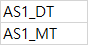

## 준비

- 라이브러리 불러오기
- 데이터셋, 사용할 변수 불러오기

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [2]:
# 데이터셋 불러오기
# dataset = pd.read_csv("dataset/Dataset_OP_230316_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230330_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230417_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230424_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
dataset = pd.read_csv("dataset/Dataset_OP_230614_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '])
dataset.head

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/Dataset_OP_230614_raw.csv'

In [ ]:
# 특성별로 분류
# var_to_use = pd.read_csv("dataset/var_to_use_2023-03-30T2240I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-21T1258I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-24T1830I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-28T1610I.csv")
var_to_use = pd.read_csv("dataset/var_to_use_2023-06-13T1650I.csv")
var_to_use


## 데이터 가공

- 기존 데이터로 새로운 데이터 만들기
- if 문 쓰면 안됨!
    - The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
- np.where 사용할 것!

### 종속변수 결측값 drop

In [ ]:
# 종속변수의 결측값이 있으면 drop
dataset.dropna(subset=['AS1_DT', 'AS1_MT'], inplace=True)

# 남성(1) drop, 여성(2)만 가져옴
dataset = dataset[dataset['AS1_SEX'] == 2]

# 새로운 종속변수 만들기 OP: 골다공증 여부
dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)
dataset.info()

### 각종 질환 가공

- 질환 유무
    - 각종 종양 유무 (AS1_TOTCA1)
- 약물력
- 가족력

In [ ]:
# 질환유무 가공
disease_list = np.array(['HT', 'DM', 'AL', 'MI', 'TH', # 질환 목록
                         'CH', 'CD', 'LP', 'AS', 'CL',
                         'KD', 'CV', 'GT' ]) # UL, PV, HN, TOTCA1 제외

dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절혐은 조건 3가지 만족하면 1 아니면 0

for x in disease_list:
    dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의. AS1_PDㅇㅇ 또는 AS1_TRTㅇㅇ 이 2이면 1 아니면 0


In [ ]:
# 약물력 가공
drug_list = np.array(['ST', 'CP', 'INS', 'HT', 'AR', 
                      'TH', 'FH', 'OS', 'STK', 'AS',
                      'LP', 'SP', 'SL'])  # UL, DM, CP, HP 제외 SP, SL 추가
for x in drug_list:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


In [ ]:
# 와 ChatGPT가 아니었다면 np.all과 np.any를 몰랐을거야!
# 가족력 가공
# N: 가족력 없음, P: parent 부모, S: sibling 형제자매, O: other 기타
# N: REL1A~4A까지 99999
# P: REL1A~4A중 1, 2 있을 때
# S: REL1A~4A중 3 있을 때
# O: REL1A~4A중 4 있을 때

# disease_dict = {
#     'HT': 4, 'DM': 4, 'CVA': 3, 'HE': 2, 'OS': 2,
#     'CVB': 2, 'CD': 2, 'PV': 2, 'LP': 2, 'GT': 2,'CH': 1
# }
disease_dict = { 'OS': 2 }

for disease, num_family in disease_dict.items():
    dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_S'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 3, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_O'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 4, axis=1).astype(int)

In [ ]:
dataset[[f'AS1_FM{disease}REL_{family}' for disease in disease_dict.keys() for family in ['N', 'P', 'S', 'O']]]

### 여성력 가공

- ~~질환~~
- 약물
- 기타 수술 (AS1_OBGYOP)
    - 자궁경부암수술/ 자궁암수술/ 자궁내막암/자궁경부암,나팔관제거수술/ 만 1 나머지는 0

In [ ]:
# 여성력 가공
# 남성 데이터 셋을 제거하여 필요없음

# 남자일 경우: 0 여자일 경우: 그대로
# for x in ['CP', 'FH']:
#     dataset['AS1_DR'+x] = np.where(dataset['AS1_SEX'] == '1',
#                                    0,
#                                    np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 2, 1))

for x in ['CP', 'FH']:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)

    
# women = np.array(['AS1_PREG', 'AS1_HYST', 'AS1_HYSTOVARYW', 'AS1_OVARYW',
#                   'AS1_OBGYOP', 'AS1_BRCA', 'AS1_DRCP', 'AS1_DRFH'])
#
# for x in women:
#     dataset[x] = np.where((dataset['AS1_SEX'] == 1), 0, dataset[x])

### 앉은 자세 혈압
- AS1_BPSit1SYS
    - AS1_BPSit1LS, AS1_BPSit1RS 변수 중 높은 값
- AS1_BPSit1DIA
    - AS1_BPSit1LD,  AS1_BPSit1RD  변수 중 높은 값

In [ ]:
dataset['AS1_BPSIT1SYS'] = np.where(dataset['AS1_BPSIT1LS'] > dataset['AS1_BPSIT1RS'], dataset['AS1_BPSIT1LS'], dataset['AS1_BPSIT1RS'])

dataset['AS1_BPSIT1DIA'] = np.where(dataset['AS1_BPSIT1LD'] > dataset['AS1_BPSIT1RD'], dataset['AS1_BPSIT1LD'], dataset['AS1_BPSIT1RD'])

### 타입 별 분리

In [ ]:
# var_to_use의 각 열 가져옴

raw_binary = dataset.reindex(columns=(var_to_use['binary'].dropna()))
raw_cath0 = dataset.reindex(columns=(var_to_use['cath0'].dropna()))
raw_cath1 = dataset.reindex(columns=(var_to_use['cath1'].dropna()))
raw_cnt = dataset.reindex(columns=(var_to_use['cnt'].dropna()))
raw_label = dataset.reindex(columns=(var_to_use['dependent'].dropna()))

In [ ]:
# null인 행이 있다.... 코드북과 데이터셋이 불일치한다.
target = raw_cnt
null_cell = pd.Series(index=target.columns)
null_cell = null_cell[target.isnull().sum() >= len(dataset)]  # 코드북에 없는 데이터 리스트
null_cell

In [ ]:
raw_label

### 결측값 대치 (문제 있음)
- 일부 데이터의 많은 결측값
  - 77777 -> 0
    - AS1_TOTALC
    - AS1_HVSMAM
  - 99999 -> ?
    - AS1_FMOSREL1A
    - AS1_CA_U
    - AS1_NA_U
    - AS1_K_U

- binary, cath0, cath1: 각 칼럼의 최빈값으로 대치
- cnt: 평균값으로 대치

In [ ]:
raw_binary = raw_binary.fillna(raw_binary.mode().iloc[0])
raw_cath0 = raw_cath0.fillna(raw_cath0.mode().iloc[0])
raw_cath1 = raw_cath1.fillna(raw_cath1.mode().iloc[0])
raw_cnt = raw_cnt.fillna(raw_cnt.mean())

### ~~데이터 균일 분포에 매핑~~ 사용 X

- 표준화 정규화 등등 사용 x
- float로 형변환만

- QuantileTransformer
> QuantileTransformer provides a non-parametric transformation to map the data to a uniform distribution with values between 0 and 1

In [ ]:
# quantile_transformer = QuantileTransformer(random_state=0)

In [ ]:
# binary = pd.DataFrame(quantile_transformer.fit_transform(raw_binary), index=dataset.index, columns=raw_binary.columns).astype('float')
# cath1 = pd.DataFrame(quantile_transformer.fit_transform(raw_cath1), index=dataset.index, columns=raw_cath1.columns).astype('float')
# cnt = pd.DataFrame(quantile_transformer.fit_transform(raw_cnt), index=dataset.index, columns=raw_cnt.columns).astype('float')
binary = raw_binary.astype('float')
cath1 = raw_cath1.astype('float')
cath0 = pd.get_dummies(raw_cath0, columns=raw_cath0.columns, drop_first=True, dtype='float64') # one-hot-encoding
cnt = raw_cnt.astype('float')

# label = pd.DataFrame(quantile_transformer.fit_transform(raw_label), index=dataset.index, columns=raw_label.columns).astype('float')

## 데이터셋에 유전체 붙이기

In [18]:
diet_and_gen = pd.concat([binary, cath0, cath1, cnt, df_all_gen], axis=1)
diet_and_gen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5217 entries, NIH2307713334 to NIH2307027315
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 5.6+ MB


In [19]:
diet_and_gen.dropna().info()
# diet_and_gen.dropna(subset=['AS1_PMYN_C'],).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4093 entries, NIH2307713334 to NIH2307534318
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 4.4+ MB


In [23]:
diet_and_gen.dropna(inplace=True)

In [ ]:
X = pd.concat([binary, cath0, cath1, cnt, df_all_gen], axis=1)
y = dataset['OP']

In [ ]:
y.value_counts()

In [21]:
X.to_csv("dataset/scaled/X_231004.csv")
y.to_csv("dataset/scaled/y_231004.csv")

X, y만 파일로 내보내고, 폐경 여부는 다른 곳에서 처리